# THIS CODE FILE SHOULD BE RUN ON JETSON NANO 4GB RAM.
## YOU MAY FACE OOM ERROR ON JETSON NANO 2GB WHILE OPTIMIZING YOUR MODEL TO TF-TRT

In [12]:
#importing the required dependencies
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [5]:
#Downloading the chest xray images for inference
!wget -O xray1.jpg https://thumbs.dreamstime.com/b/normal-chest-ray-patient-74660496.jpg
!wget -O xray2.jpg https://www.news-medical.net/image.axd?picture=2020%2F6%2Fshutterstock_786937069.jpg

--2021-08-20 15:04:02--  https://thumbs.dreamstime.com/b/normal-chest-ray-patient-74660496.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73221 (72K) [image/jpeg]
Saving to: ‘xray1.jpg’

xray1.jpg           100%[===================>]  71.50K  --.-KB/s    in 0.01s   

2021-08-20 15:04:02 (6.70 MB/s) - ‘xray1.jpg’ saved [73221/73221]

--2021-08-20 15:04:02--  https://www.news-medical.net/image.axd?picture=2020%2F6%2Fshutterstock_786937069.jpg
Resolving www.news-medical.net (www.news-medical.net)... 104.20.84.7, 104.20.85.7
Connecting to www.news-medical.net (www.news-medical.net)|104.20.84.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80573 (79K) [image/jpeg]
Saving to: ‘xray2.jpg’

xray2.jpg           100%[===================>]  78.68K  --.-KB/s    in 0.03s   

2021-08-20 15:04:

In [7]:
#pre-processing image to pass into the model
img = tf.keras.preprocessing.image.load_img('xray1.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

In [8]:
img = tf.keras.preprocessing.image.load_img('xray2.jpg', target_size=(224, 224))
y = tf.keras.preprocessing.image.img_to_array(img)
y = np.expand_dims(y, axis=0)
y = tf.keras.applications.mobilenet_v2.preprocess_input(y)

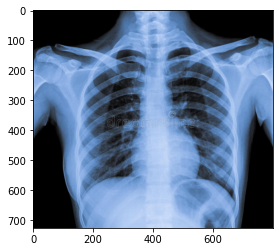

In [9]:
#plotting the image
image_1 = plt.imread('xray1.jpg')
plt.imshow(image_1)
plt.show()

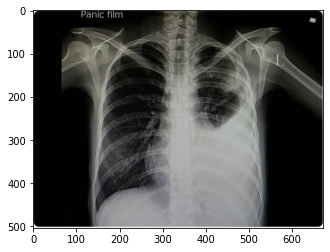

In [10]:
#chest xray plot
image_2 = plt.imread('xray2.jpg')
plt.imshow(image_2)
plt.show()

In [17]:
# Looking at the meta data of the model and serving_default (Note: please not the output node info in our model the output node name is : dense_2)
!saved_model_cli show --all --dir mobilenet_custom_model/


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0820 15:12:43.463725 140104495753088 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/r

In [13]:
#saving the params to which precision_mode we want to convert
params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
  precision_mode='FP16',)

In [14]:
# using tf-trt to optimize our model for jetson nano inferencing
converter = trt.TrtGraphConverterV2(
      input_saved_model_dir='mobilenet_custom_model',
      conversion_params=params)
converter.convert()

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


<ConcreteFunction pruned(input_1) at 0x7F1D23914950>

In [15]:
#saving the model
saved_model_dir_trt = 'mobilenet_v2_custom_model.trt'
converter.save(saved_model_dir_trt)

INFO:tensorflow:Assets written to: mobilenet_v2_custom_model.trt/assets


In [16]:
#loading the optimized tf-trt model and it's serving default
root = tf.saved_model.load(saved_model_dir_trt)
concrete_func = root.signatures['serving_default']

In [19]:
# Inferencing using the optimized tf-trt model and getting the predictions
labeling = concrete_func(tf.constant(x.astype('float32')))
activations = tf.nn.softmax(labeling['dense_2'])
class_names = ['Normal','Pneumonia']
string = "This particular image most likely is :"+class_names[np.argmax(activations)]
print(string)

This particular image most likely is :Normal


In [20]:
labeling = concrete_func(tf.constant(y.astype('float32')))
activations = tf.nn.softmax(labeling['dense_2'])
class_names = ['Normal','Pneumonia']
string = "This particular image most likely is :"+class_names[np.argmax(activations)]
print(string)

This particular image most likely is :Pneumonia
